In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from modules.csvLoader import csvLoader

%load_ext autoreload
%autoreload 2

## Définition de fonctions utiles

In [2]:
def drop_extreme(df, colonne, low_qt, high_qt):
    limite_basse, limite_haute = df[colonne].quantile([low_qt, high_qt])
    # print(limite_basse, ' ', limite_haute)
    return df.query("{low}<=`{colonne}`<={high}".format(low=limite_basse,high=limite_haute,colonne=colonne))

## Lecture des csv

In [3]:
appartement_filtre = csvLoader.load('appartement')

Successfully loaded  appartement.csv


## Observation sur les types de mutation et leur influence sur la valeur de l'appartement

In [4]:
mutations = appartement_filtre['Nature mutation'].drop_duplicates().tolist()
for mutation in mutations:
    df = appartement_filtre[appartement_filtre['Nature mutation']==mutation]
    print('nb ', mutation[:15], ' :\t', len(df), '\tsoit\t', round(len(df)/len(appartement_filtre)*100, 2), ' % des appartements' )

del(mutation, mutations, df)

print()
print('Valeur moyenne par type de bien')
maison_valeur = appartement_filtre[['Nature mutation', 'Valeur fonciere']]
print( maison_valeur.groupby(['Nature mutation']).mean().head() )

del(maison_valeur)

print()
print(len(appartement_filtre))
appartement_filtre = appartement_filtre[appartement_filtre['Nature mutation'] == 'Vente']
print(len(appartement_filtre))

nb  Vente  :	 419899 	soit	 97.97  % des appartements
nb  Vente en l'état  :	 6202 	soit	 1.45  % des appartements
nb  Echange  :	 914 	soit	 0.21  % des appartements
nb  Adjudication  :	 1344 	soit	 0.31  % des appartements
nb  Vente terrain à  :	 244 	soit	 0.06  % des appartements
nb  Expropriation  :	 6 	soit	 0.0  % des appartements

Valeur moyenne par type de bien
                                    Valeur fonciere
Nature mutation                                    
Adjudication                           3.705178e+05
Echange                                1.737324e+05
Expropriation                          1.068143e+07
Vente                                  2.545757e+06
Vente en l'état futur d'achèvement     4.735143e+05

428609
419899


## Observation sur les ventes groupées/dupliquées

précédemment avec 'Voie' dans le subset de filtre drop duplicates:
- 419899
- 283862

In [5]:
# appartement_filtre.columns.tolist()
# vente_groupe = appartement_filtre.groupby(['Date mutation', 'Valeur fonciere', 'Voie', 'Code postal','Commune'])

print(len(appartement_filtre))
appartement_filtre = appartement_filtre.drop_duplicates(['Date mutation', 'Valeur fonciere', 'Code postal'], keep=False)
print(len(appartement_filtre))

419899
280283


## Suppression des extremes de Nombre de pieces

In [6]:
print(len(appartement_filtre))
appartement_filtre = drop_extreme(appartement_filtre, 'Nombre pieces principales', 0.1, 0.9)
print(len(appartement_filtre))

nb_pieces = appartement_filtre['Nombre pieces principales'].drop_duplicates().tolist()
nb_pieces.sort()
for piece in nb_pieces:
    df = appartement_filtre[appartement_filtre['Nombre pieces principales']==piece]
    print(int(piece), ' pièces :', len(df), '\tsoit\t', round(len(df)/len(appartement_filtre)*100, 2), ' % des appartements' )

del(nb_pieces, df, piece)

280283
264844
1  pièces : 47315 	soit	 17.87  % des appartements
2  pièces : 83594 	soit	 31.56  % des appartements
3  pièces : 86638 	soit	 32.71  % des appartements
4  pièces : 47297 	soit	 17.86  % des appartements


## Observation sur les lots

la plupart des lots n'ont pas leur surface renseignée

In [7]:
# lots = ['1er lot', 'Surface Carrez du 1er lot', '2eme lot', 'Surface Carrez du 2eme lot', '3eme lot', 'Surface Carrez du 3eme lot', '4eme lot',
#  'Surface Carrez du 4eme lot', '5eme lot', 'Surface Carrez du 5eme lot']

# print(len(appartement_filtre))
# for lot in lots:
#     print(
#         lot,
#         ' : ', 
#         len(appartement_filtre) - len(appartement_filtre[appartement_filtre[lot].isna()]),
#         'appartements soit',
#         round(100 - len( appartement_filtre[appartement_filtre[lot].isna()] ) / len(appartement_filtre) * 100, 2),
#         '% des appartements.'
#     )

# print()
# df_emelot = appartement_filtre[appartement_filtre['1er lot'].notna()]
# nb_emelot = len(appartement_filtre[appartement_filtre['1er lot'].notna()])
# print('eme lot : ', nb_emelot)
# for lot in lots:
#     print(
#         len(appartement_filtre[appartement_filtre[lot].notna()]),
#         lot,
#         ' soit',
#         round( len(appartement_filtre[appartement_filtre[lot].notna()]) / nb_emelot * 100, 2),
#         '% des eme lots '
#     )

# del(lot, lots, nb_emelot, df_emelot)

# print()
# print('Pourcentage des apparts sans lot')
# print(
#     len(appartement_filtre[appartement_filtre['1er lot'].isna()]),
#     ' soit ',
#     round(len(appartement_filtre[appartement_filtre['1er lot'].isna()]) / len(appartement_filtre) * 100, 2),
#     '% des appartement'
#  )

## Filtre sur les colonnes inutiles et concatenation des colonnes 'Surface Carrez' et 'Surface reelle'

Je décide de conserver la surface carrez du premier lot

In [8]:
print('filtre des lots:')
print(len(appartement_filtre))
appartement_filtre = appartement_filtre[appartement_filtre['Nombre de lots'] < 2]
print(len(appartement_filtre))

appartement_filtre = appartement_filtre[['Date mutation', 'Nature mutation', 'Valeur fonciere', 'Code postal', 'Voie', 'Commune', 'Surface Carrez du 1er lot', 'Nombre de lots', 'Type local', 'Surface reelle bati', 'Nombre pieces principales', 'Surface terrain']]

import math

def set_surface(row):
    if not math.isnan(row['Surface Carrez du 1er lot']):
        return row['Surface Carrez du 1er lot']
    return row['Surface reelle bati']

appartement_filtre['Surface'] = appartement_filtre.apply(set_surface, axis=1)
# 'Surface reelle bati'
appartement_filtre = appartement_filtre.drop(columns=['Surface Carrez du 1er lot', 'Nombre de lots'])

filtre des lots:
264844
140116


## Suppression des extremes de Surface

In [9]:
print(len(appartement_filtre))
appartement_filtre = drop_extreme(appartement_filtre, 'Surface', 0.1, 0.9)
print(len(appartement_filtre))

print(appartement_filtre['Surface'].min(), appartement_filtre['Surface'].max())

140116
112101
22.25 81.02


## Suppression des extremes de 'Surface terrain'

- Subtilité: la plupart des appartements n'ont pas de terrain
- Note: j'ai décide de drop la colonne 'Surface terrain'

In [10]:
print(len(appartement_filtre))
appartement_filtre = appartement_filtre[appartement_filtre['Surface terrain'].isna()]
print(len(appartement_filtre))

appartement_filtre = appartement_filtre.drop(columns=['Surface terrain'])

112101
109725


## Suppression des extremes de 'Valeur fonciere'

109725
92197
55000.0 326850.0
taille du sample :  18439


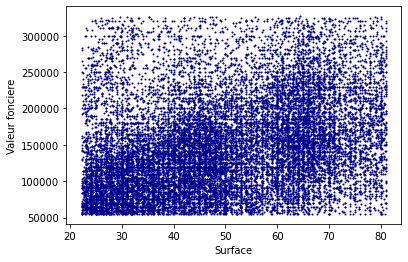

In [11]:
print(len(appartement_filtre))
appartement_filtre = drop_extreme(appartement_filtre, 'Valeur fonciere', 0.08, 0.92)
print(len(appartement_filtre))

print(appartement_filtre['Valeur fonciere'].min(), appartement_filtre['Valeur fonciere'].max())

nb_sample = round(0.2*len(appartement_filtre))
print('taille du sample : ', nb_sample)
plot = appartement_filtre.sample(n=nb_sample).plot.scatter(x='Surface', y='Valeur fonciere', c='DarkBlue', s=1)
del(nb_sample, plot)

## Observation du prix au m²

92197
77452
1711.929118535078 4915.764315742799


<AxesSubplot:>

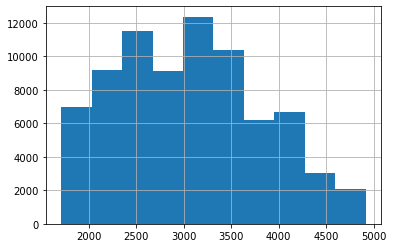

In [12]:
appartement_filtre['Prix metre carre'] = appartement_filtre['Valeur fonciere']/appartement_filtre['Surface']
valeur_surface = appartement_filtre.groupby('Code postal')['Prix metre carre'].mean()

# Generation du csv prix au metre carre
csvLoader.save(valeur_surface, 'prix_metre_appartement.csv')

appartement_filtre = appartement_filtre.merge(valeur_surface, on='Code postal')
appartement_filtre = appartement_filtre.drop(columns=['Prix metre carre_x'])
appartement_filtre = appartement_filtre.rename(columns={'Prix metre carre_y':'Prix metre carre'})

# Je test d'éliminer les extrèmes de prix au m²
print(len(appartement_filtre))
appartement_filtre = drop_extreme(appartement_filtre, 'Prix metre carre', 0.08, 0.92)
print(len(appartement_filtre))

appartement_filtre = appartement_filtre.drop(columns=['Code postal'])
# del(valeur_surface)
print(appartement_filtre['Prix metre carre'].min(), appartement_filtre['Prix metre carre'].max())
appartement_filtre['Prix metre carre'].hist()

# Analyses et Graphs

## Relation de la surface (Y) avec le prix (X)

taille du sample :  15490


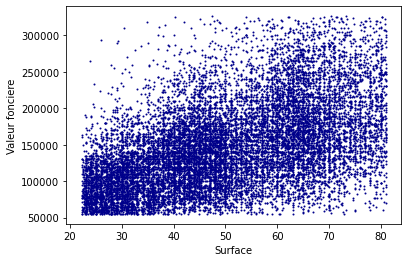

In [13]:
nb_sample = round(0.2*len(appartement_filtre))
print('taille du sample : ', nb_sample)
plot = appartement_filtre.sample(n=nb_sample).plot.scatter(x='Surface', y='Valeur fonciere', c='DarkBlue', s=1)
del(nb_sample, plot)

## Relation du prix au metre (Y) avec le prix (X)

taille du sample :  15490


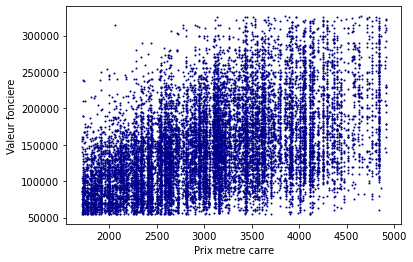

In [14]:
nb_sample = round(0.2*len(appartement_filtre))
print('taille du sample : ', nb_sample)
plot = appartement_filtre.sample(n=nb_sample).plot.scatter(x='Prix metre carre', y='Valeur fonciere', c='DarkBlue', s=1)
del(nb_sample, plot)

<AxesSubplot:>

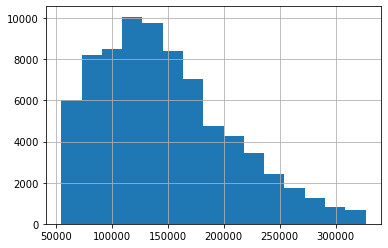

In [15]:
appartement_filtre['Valeur fonciere'].hist(bins=15)

## Recherche de correlation

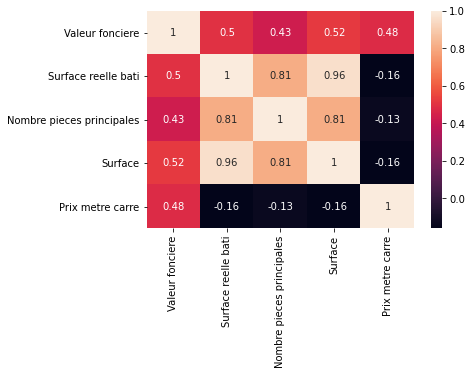

In [16]:
matrice = appartement_filtre.corr().round(2)
sns.heatmap(data=matrice, annot=True)
del(matrice)

In [17]:
print(len(appartement_filtre))
csvLoader.save(appartement_filtre, 'appartement_filtre', save_index=False)

77452
